In [767]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import shutil
from io import BytesIO
from pathlib import Path
import itertools
import sys

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/tests/supermolecule")
# from supermol import compute_interaction_energy

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/helper_functions/")
# from basis import *


import ase
from ase import Atoms, io
from ase.data import covalent_radii
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs
from ase.visualize.plot import plot_atoms
from pathlib import Path
import numpy as np
import ase
from ase.io import read
from ase.visualize import view


from sklearn.decomposition import PCA

default_color_dict = {
    "Cl": [102, 227, 115],
    "C": [61, 61, 64],
    "O": [240, 10, 10],
    "N": [10, 10, 240],
    "F": [0, 232, 0],
    "H": [232, 206, 202],
    "K": [128, 50, 100],
    "X": [200, 200, 200],
}



def render_povray(
    atoms, pov_name, rotation="0x, 0y, 0z", radius_scale=0.25, color_dict=None,
    vectors = None, angles = None, planes = None,
):

    # align the molecule to the principal axes
    pca = PCA(n_components=3)
    pca.fit(atoms.get_positions())
    atoms.set_positions(pca.transform(atoms.get_positions()))

    if color_dict is None:
        color_dict = default_color_dict

    path = Path(pov_name)
    pov_name = path.name
    base = path.parent

    radius_list = []
    for atomic_number in atoms.get_atomic_numbers():
        radius_list.append(radius_scale * covalent_radii[atomic_number])

    colors = np.array([color_dict[atom.symbol] for atom in atoms]) / 255

    bondpairs = get_bondpairs(atoms, radius=0.9)
    good_bonds = []
    good_bond_keys = []
    for _ in bondpairs:
        #  remove the Cl-Cl bonds
        if not (atoms[_[0]].symbol == "Cl" and atoms[_[1]].symbol == "Cl"):
            good_bonds.append(_)
            good_bond_keys.append((_[0], _[1]))
            good_bond_keys.append((_[1], _[0]))

    # create hydrogen bonds
    _pos = atoms.get_positions()
    _z = atoms.get_atomic_numbers()
    idx_onh = (_z == 8) | (_z == 1) | (_z == 7)
    idxs = np.where(idx_onh)[0]

    # create a mapping between atom idxs in the first atoms object
    # and the idxs in the new atoms object
    map = {}
    for i, idx in enumerate(idxs):
        map[i] = idx
    # create a new atoms object with only N, O and H atoms
    atoms_onh = Atoms(_z[idxs], _pos[idxs])
    bondpairs_onh = get_bondpairs(atoms_onh, radius=1.5)
    for _ in bondpairs_onh:
        if (map[_[0]], map[_[1]]) not in good_bond_keys:
            distance = np.linalg.norm(_pos[_[0]] - _pos[_[1]])
            # check that atom1 is H or N/O and atom2 is N/O or H
            if (_z[_[0]] == 1 and (_z[_[1]] == 7 or _z[_[1]] == 8)) or (
                _z[_[1]] == 1 and (_z[_[0]] == 7 or _z[_[0]] == 8)
            ):
                if 1.0 < distance < 3.5:
                    print(f"Adding bond between", map[_[0]], map[_[1]])
                    good_bonds.append(_)

    good_bonds = set_high_bondorder_pairs(good_bonds)

    kwargs = {  # For povray files only
        "transparent": True,  # Transparent background
        "canvas_width": 1028*2,  # Width of canvas in pixels
        "canvas_height": None,  # None,  # Height of canvas in pixels
        "camera_dist": 10,  # Distance from camera to front atom,
        "camera_type": "orthographic angle 0",  # 'perspective angle 20'
        "depth_cueing": False,
        "colors": colors,
        "bondatoms": good_bonds,
        "textures": ["jmol"] * len(atoms),
        'image_plane'  : None,
    }

    generic_projection_settings = {
        "rotation": rotation,
        "radii": radius_list,
    }

    povobj = io.write(
        pov_name, atoms, **generic_projection_settings, povray_settings=kwargs
    )


    from ase.io.utils import PlottingVariables
    pvars = PlottingVariables(ase_atoms, scale=1,
                              **generic_projection_settings)
    R = pvars.positions
    w = pvars.w
    h = pvars.h
    z0 = R[:, 2].max()
    shift = (w /2 , h /2 , z0)
    
    R = pvars.positions[:len(atoms)] - shift
    

    
    def center_normal(plane):
        plane = np.array(plane)
        center = plane.T.mean(axis=1)
        return center, np.linalg.norm(plane.T, axis=1)


    with open("render_povray.pov") as f:
        lines = f.readlines()
        
    with open(pov_name, "a") as f:
        for l in lines:
            f.write(l)
        
        def format_vec(array):
            """Povray array syntax"""
            return '<' + ', '.join(f"{x:>6.2f}" for x in tuple(array)) + '>'
                    
        if angles:

            angles = [[R[_[0]], R[_[1]], R[_[2]]] for _ in angles]
            for a in angles:
                dist = np.sum((a[2] - a[0])**2)**0.5
                print(dist)
                a = [format_vec(_) for _ in a]
                f.write(f"\nAngleMarker({a[0]}, {a[1]}, {a[2]}, {dist})\n")
    
        if planes:
            planes = [[R[_[0]], R[_[1]], R[_[2]]] for _ in planes]
            for p in planes:
                p = center_normal(p)
                p = [format_vec(_) for _ in p]
                f.write(f"\nPlane({p[0]}, {p[1]}, 0.1, 0.01)\n")
    
        if vectors:
            vectors = [[R[_[0]], R[_[1] ]] for _ in vectors]

            for v in vectors:
                v = [format_vec(_) for _ in v]
                f.write(f"\nArrow({v[0]}, {v[1]}, 0.02, 0.01)\n")


    
    povobj.render(
        povray_executable="/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/bin/povray"
    )
    png_name = pov_name.replace(".pov", ".png")
    shutil.move(png_name, base / png_name)
    
    return png_name, povobj
import pandas as pd


def process_data(intE_final_results, n_atoms=10):
    intE_results = pd.DataFrame([intE_final_results["intE_results"]])

    standard_res = {k:v for k,v in intE_final_results.items() if k != "intE_results"}
    standard_res.pop("results_A_ghost")
    standard_res.pop("results_B_ghost")


    def scalar_cols(key, v, n=n_atoms):
        axs = ["x", "y", "z"]
        return {key + f"_{i}_{axs[j]}": v[i][j] if i < v.shape[0] else 0 for i in range(n) for j in range(3)}
    
    def scalar_cols_hess(key, v, n=n_atoms):
        axs = ["x", "y", "z"]
        return {key + f"_{i}_{j}": v[i][j] if (i < v.shape[0] and j < v.shape[1]) else 0 for i in range(n*3) for j in range(n*3)}
    
    standard_res_scaler = { k:  { kk: vv for kk,vv in v.items() if kk in ["energy"]} for k,v in standard_res.items()}

    standard_res_gradient = { k:  [scalar_cols(kk, vv, n_atoms) for kk, vv in v.items() if kk == "gradient"] for k,v in standard_res.items()}
    gradients = {k: pd.DataFrame(standard_res_gradient[k]).to_numpy().reshape(n_atoms, 3) for k in standard_res_gradient.keys()}
    
    standard_res_hessian = { k:  [scalar_cols_hess(kk, vv, n_atoms) for kk, vv in v.items() if kk == "hessian"] for k,v in standard_res.items()}
    hessian = {k: pd.DataFrame(standard_res_hessian[k]).to_numpy().reshape(n_atoms, 3, n_atoms, 3) for k in standard_res_hessian.keys()}
    
    thermo_results = []
    keys = list(standard_res.keys())
    for key in keys:
        old  = standard_res[key]["thermo"]
        new = {}
        for k, v in old.items():
            if type(v) is tuple:
                if k != "rot_const":
                    value, unit = tuple(v)
                    if unit == "":
                        unit = "unitless"
                    new[k+"_"+unit] = value
                else:
                    value, unit = tuple(v)
                    new[k+"_x_"+unit] = value[0]
                    new[k+"_y_"+unit] = value[0]
                    new[k+"_z_"+unit] = value[0]
        thermo_results.append(new)
    
    thermo_results_df = pd.DataFrame(thermo_results, index=keys)

    output =     {    "thermo_results_df": thermo_results_df,
        "intE_results": intE_results, 
        "gradients": gradients, 
        "hessians": hessian, 
        "results": standard_res,
        }
    
    import numpy as np
    assert np.all(output["thermo_results_df"].index == ['results_AB', 'results_A', 'results_B'])
    formation_thermo = pd.DataFrame(output["thermo_results_df"].iloc[0] - output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])
    delta_thermo = pd.DataFrame(output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])
    mean_thermo = pd.DataFrame( (output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])/2)
    delta_keys = pd.DataFrame(delta_thermo)
    
    final_output = {
        "formation_thermo": formation_thermo,
        "delta_thermo": delta_thermo ,
        "mean_thermo": mean_thermo ,
        "delta_keys": delta_keys,
    }
    final_output.update(output)
    return final_output

dpi = 300
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

import dscribe
import pandas as pd

from ase import Atoms
from pyscf import gto

def pyscf_to_ase(mol):
    """Convert a PySCF Mole object to an ASE Atoms object."""
    symbols = [mol.atom_symbol(i) for i in range(mol.natm)]
    positions = mol.atom_coords(unit="Angstrom")
    return Atoms(symbols, positions=positions)



In [776]:
fns = Path("/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/").glob("*pickle")
fns = list(fns)
fns

[PosixPath('/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/qm_calcs_1.pickle'),
 PosixPath('/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990.pickle'),
 PosixPath('/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/qm_calcs_275ed3a6-3e6a-42a6-a901-e3ae640f7de0.pickle')]

In [777]:
fn = fns[-1]
print(fn)
data = pd.read_pickle(fn)

/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/qm_calcs_275ed3a6-3e6a-42a6-a901-e3ae640f7de0.pickle


In [795]:
data_arrays = [pd.read_pickle(fn) for fn in fns]

data = {}
for i in range(len(fns)):
    key_append = str(fns[i].stem) + "/"
    _ = data_arrays[i]
    _ = {(key_append + k[0], k[1], k[2]): v for k,v in _.items()}
    data.update(_)

In [796]:
data.keys()

dict_keys([('qm_calcs_1/mini.pdb', 8, 239), ('qm_calcs_1/mini.pdb', 19, 239), ('qm_calcs_1/mini.pdb', 10, 239), ('qm_calcs_1/mini.pdb', 14, 239), ('qm_calcs_1/mini.pdb', 0, 239), ('qm_calcs_1/mini.pdb', 12, 239), ('qm_calcs_1/mini.pdb', 15, 239), ('qm_calcs_1/mini.pdb', 1, 239), ('qm_calcs_1/heat.pdb', 18, 265), ('qm_calcs_1/heat.pdb', 17, 265), ('qm_calcs_1/equi.pdb', 11, 52), ('qm_calcs_1/equi.pdb', 16, 52), ('qm_calcs_1/equi.pdb', 18, 52), ('qm_calcs_1/equi.pdb', 1, 52), ('qm_calcs_1/equi.pdb', 0, 52), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 5, 151), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 13, 33), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 8, 33), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 1, 33), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 17, 33), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 5, 33), ('qm_calcs_6441fb6f-14d2-4232-be30-68144a52b990/mini.pdb', 7, 33), ('qm_calcs_6441fb

In [797]:
keys = data.keys()
len(keys)

654

In [799]:
k = list(keys)

# data[k].keys()
monomer_keys = []
key_idxs = []
for i, _ in enumerate(k):
    a = ("a", _[0], _[1])
    b = ("b",_[0], _[2])
    if a not in monomer_keys:
        monomer_keys.append(a)
        key_idxs.append(i)
    if b not in monomer_keys:
        monomer_keys.append(b)
        key_idxs.append(i)
len(monomer_keys), monomer_keys[0]

(702, ('a', 'qm_calcs_1/mini.pdb', 8))

In [802]:
monomer_energies = []
monomer_coords = []
monomer_elements = []
monomer_ases = []
monomer_gradients = []

for i, (ab, _, _) in zip(key_idxs, monomer_keys):

    if ab == "a":
        E = data[k[i]]["results"]["results_A"]["energy"]
        mol = data[k[i]]["results"]["results_A"]["mol"]
        monomer_ases.append(pyscf_to_ase(mol))
        monomer_elements.append(monomer_ases[-1].get_atomic_numbers())
        monomer_coords.append(monomer_ases[-1].get_positions())
        monomer_gradients.append(data[k[i]]["results"]["results_A"]["gradient"])

    elif ab == "b":
        E = data[k[i]]["results"]["results_B"]["energy"]
        mol = data[k[i]]["results"]["results_B"]["mol"]
        monomer_elements.append(monomer_ases[-1].get_atomic_numbers())
        monomer_coords.append(monomer_ases[-1].get_positions())
        monomer_gradients.append(data[k[i]]["results"]["results_B"]["gradient"])
        monomer_ases.append(pyscf_to_ase(mol))
    else:
        pass

    monomer_energies.append(E)
# 

In [803]:
monomer_coords

[array([[ 2.726, 11.277, 10.116],
        [ 2.829, 10.77 ,  9.135],
        [ 1.784, 10.975, 10.621],
        [ 2.705, 13.043,  9.849],
        [ 4.116, 10.834, 11.15 ]]),
 array([[ 2.726, 11.277, 10.116],
        [ 2.829, 10.77 ,  9.135],
        [ 1.784, 10.975, 10.621],
        [ 2.705, 13.043,  9.849],
        [ 4.116, 10.834, 11.15 ]]),
 array([[ 1.378,  2.89 , 12.883],
        [ 0.292,  3.113, 12.845],
        [ 1.571,  1.83 , 12.617],
        [ 1.977,  3.187, 14.54 ],
        [ 2.229,  3.948, 11.721]]),
 array([[-3.467,  6.508,  5.855],
        [-3.681,  5.746,  5.077],
        [-3.855,  6.188,  6.845],
        [-4.252,  8.045,  5.39 ],
        [-1.7  ,  6.741,  5.98 ]]),
 array([[ 7.635, -5.034, 15.04 ],
        [ 6.637, -4.605, 15.263],
        [ 7.82 , -5.084, 13.947],
        [ 7.724, -6.687, 15.706],
        [ 8.892, -4.01 , 15.79 ]]),
 array([[10.886,  5.788,  8.782],
        [11.777,  5.875,  8.128],
        [10.432,  6.784,  8.965],
        [11.384,  5.091, 10.347],
    

In [804]:
combined_xyz_str = "" #open("combined.xyz", "a")


for i in range(len(monomer_ases)):
    a = monomer_elements[i]
    xyz = monomer_coords[i]
    grad = monomer_gradients[i]
    e = monomer_energies[i]
    nat = len(a)
    combined_xyz_str += f"{nat}\n{e}\n"
    for i, ixyz, igrad in zip([1,2,3,4,0], xyz, grad):
        # ixyz *= 1.8897259886
        ixyz = str(ixyz).strip("[").strip("]")
        igrad = str(igrad).strip("[").strip("]")
        s = ase.data.chemical_symbols[a[i]]
        xyz_grad = f"{s} {ixyz} {igrad}\n"
        combined_xyz_str += xyz_grad
    combined_xyz_str += "\n"
print(combined_xyz_str)
with open("combined.xyz", "w") as f:
    f.write(combined_xyz_str)

5
-959.7495161173356
H  2.726 11.277 10.116 0.00815773 0.00788034 0.00450622
H  2.829 10.77   9.135 -0.00081701 -0.00545512 -0.00938725
Cl  1.784 10.975 10.621 -0.01053087 -0.00435139  0.00347135
Cl  2.705 13.043  9.849  0.00393268 -0.00329793  0.00287335
C  4.116 10.834 11.15  -0.00073819  0.0052249  -0.00146204

5
-959.7495597937918
H  2.726 11.277 10.116  0.01003293 -0.00705671  0.00075147
H  2.829 10.77   9.135 -0.00402434  0.01016926  0.00567207
Cl  1.784 10.975 10.621 -0.00825413 -0.00143609 -0.00567677
Cl  2.705 13.043  9.849  0.00337157  0.00248194 -0.00456999
C  4.116 10.834 11.15  -0.00112201 -0.00415984  0.00382604

5
-959.749589588956
H  1.378  2.89  12.883 0.00876578 0.00872074 0.00307867
H  0.292  3.113 12.845 -1.10215459e-02  7.39132383e-05 -1.05607330e-03
Cl  1.571  1.83  12.617 -0.00021224 -0.01100103 -0.00268469
Cl  1.977  3.187 14.54   0.00167609  0.0022615  -0.00450177
C  2.229  3.948 11.721  7.93880953e-04 -5.16904893e-05  5.16044618e-03

5
-959.7495166429314
H -3.

In [749]:
ase.io.write("test.xyz", monomer_ases[0], comment='hello')

In [750]:
view(monomer_ases[0], viewer="x3d")

In [751]:
data[k[0]].keys()


dict_keys(['formation_thermo', 'delta_thermo', 'mean_thermo', 'delta_keys', 'thermo_results_df', 'intE_results', 'gradients', 'hessians', 'results', 'distances_'])

In [754]:
results_data = [data[k]["results"] for k in keys] 


atoms = pyscf_to_ase(results_data[0]["results_AB"]["mol"])

view(atoms, viewer="x3d")

In [755]:
results_data[0]["results_AB"].keys()
symbols_ = ase.data.chemical_symbols

In [756]:
import matplotlib

import seaborn as sns


fig.subfigures(2, 1, wspace=0.07)
plt.show()


In [757]:
nms = results_data[3]["results_A"]["harmonic"]["norm_mode"]
print(nms.shape)

def nms_plot(nms, elements = [], fig=None):
    if fig == None:
        fig = plt.figure(layout='constrained', figsize=(4, 10))

    subfigs = fig.subfigures(2, 1,
                             # wspace=0.07,
                             height_ratios=[1,5])

    
    _, _, _, MIN, _, _, _, MAX = pd.DataFrame([nms.flatten()]).T.describe().to_numpy()
    color_code = ase.data.colors.jmol_colors
    element_colors = [matplotlib.colors.to_rgb(color_code[symbols_.index(x)]) for x in elements]
    n_nms = nms.shape[0]
    import math
    # rows = math.gcd(n_nms//3, n_nms)
    columns = int(np.sqrt(n_nms) // 1)
    rows = int(np.sqrt(n_nms) // 1)
    if rows*columns < n_nms:
        columns += 1
    n_nms = nms.shape[0]
    n_at = nms.shape[1]

    ax = subfigs[0].subplots(1, 1, 
                             # figsize=(10,10),
                            )
    spectral = sns.color_palette("Spectral", as_cmap=True)
    ir=result_a["harmonic"]["freq_wavenumber"]
    for i, x in enumerate(result_a["harmonic"]["freq_wavenumber"]):
        ax.axvline(x, color=spectral(x/3500), linewidth=3
                  )
    
    ax.set_xlim(0, 3500)
    
    axes = subfigs[1].subplots(rows, columns, 
                             # figsize=(10,10),
                            )
    for j in range(rows):
        for i in range(columns):
            # print(nms[i%6, i//4].shape)
            axes[j,i].set_title(f"{i+j*columns+1}",
                                fontsize=20,
                                alpha=1,
                                backgroundcolor=spectral(ir[i+j*columns]/3500))
            m = axes[j,i].matshow(nms[i+j*columns], 
                              cmap= "Spectral",#"bwr",
                             vmin=MIN, vmax=MAX
                             )
            axes[j,i].xaxis.set_ticks([0, 1, 2], 
                                      ["$x$", "$y$", "$z$"],
                                      fontsize=20,
                                     )
            axes[j,i].yaxis.set_ticks(range(n_at), 
                                      elements,
                                      fontsize=20
                                     )
            # subfigs[1].colorbar(m, orientation='vertical')
    
            for c, (i,t) in enumerate(zip(element_colors, 
                             axes[j,i].yaxis.get_ticklabels())):
                t.set_color(i) 
                if elements[c] == "H":
                    # t.set_backgroundcolor("#55555555")
                    t.set_color("k") 
    plt.show()
    return subfigs
                    

    


(9, 5, 3)


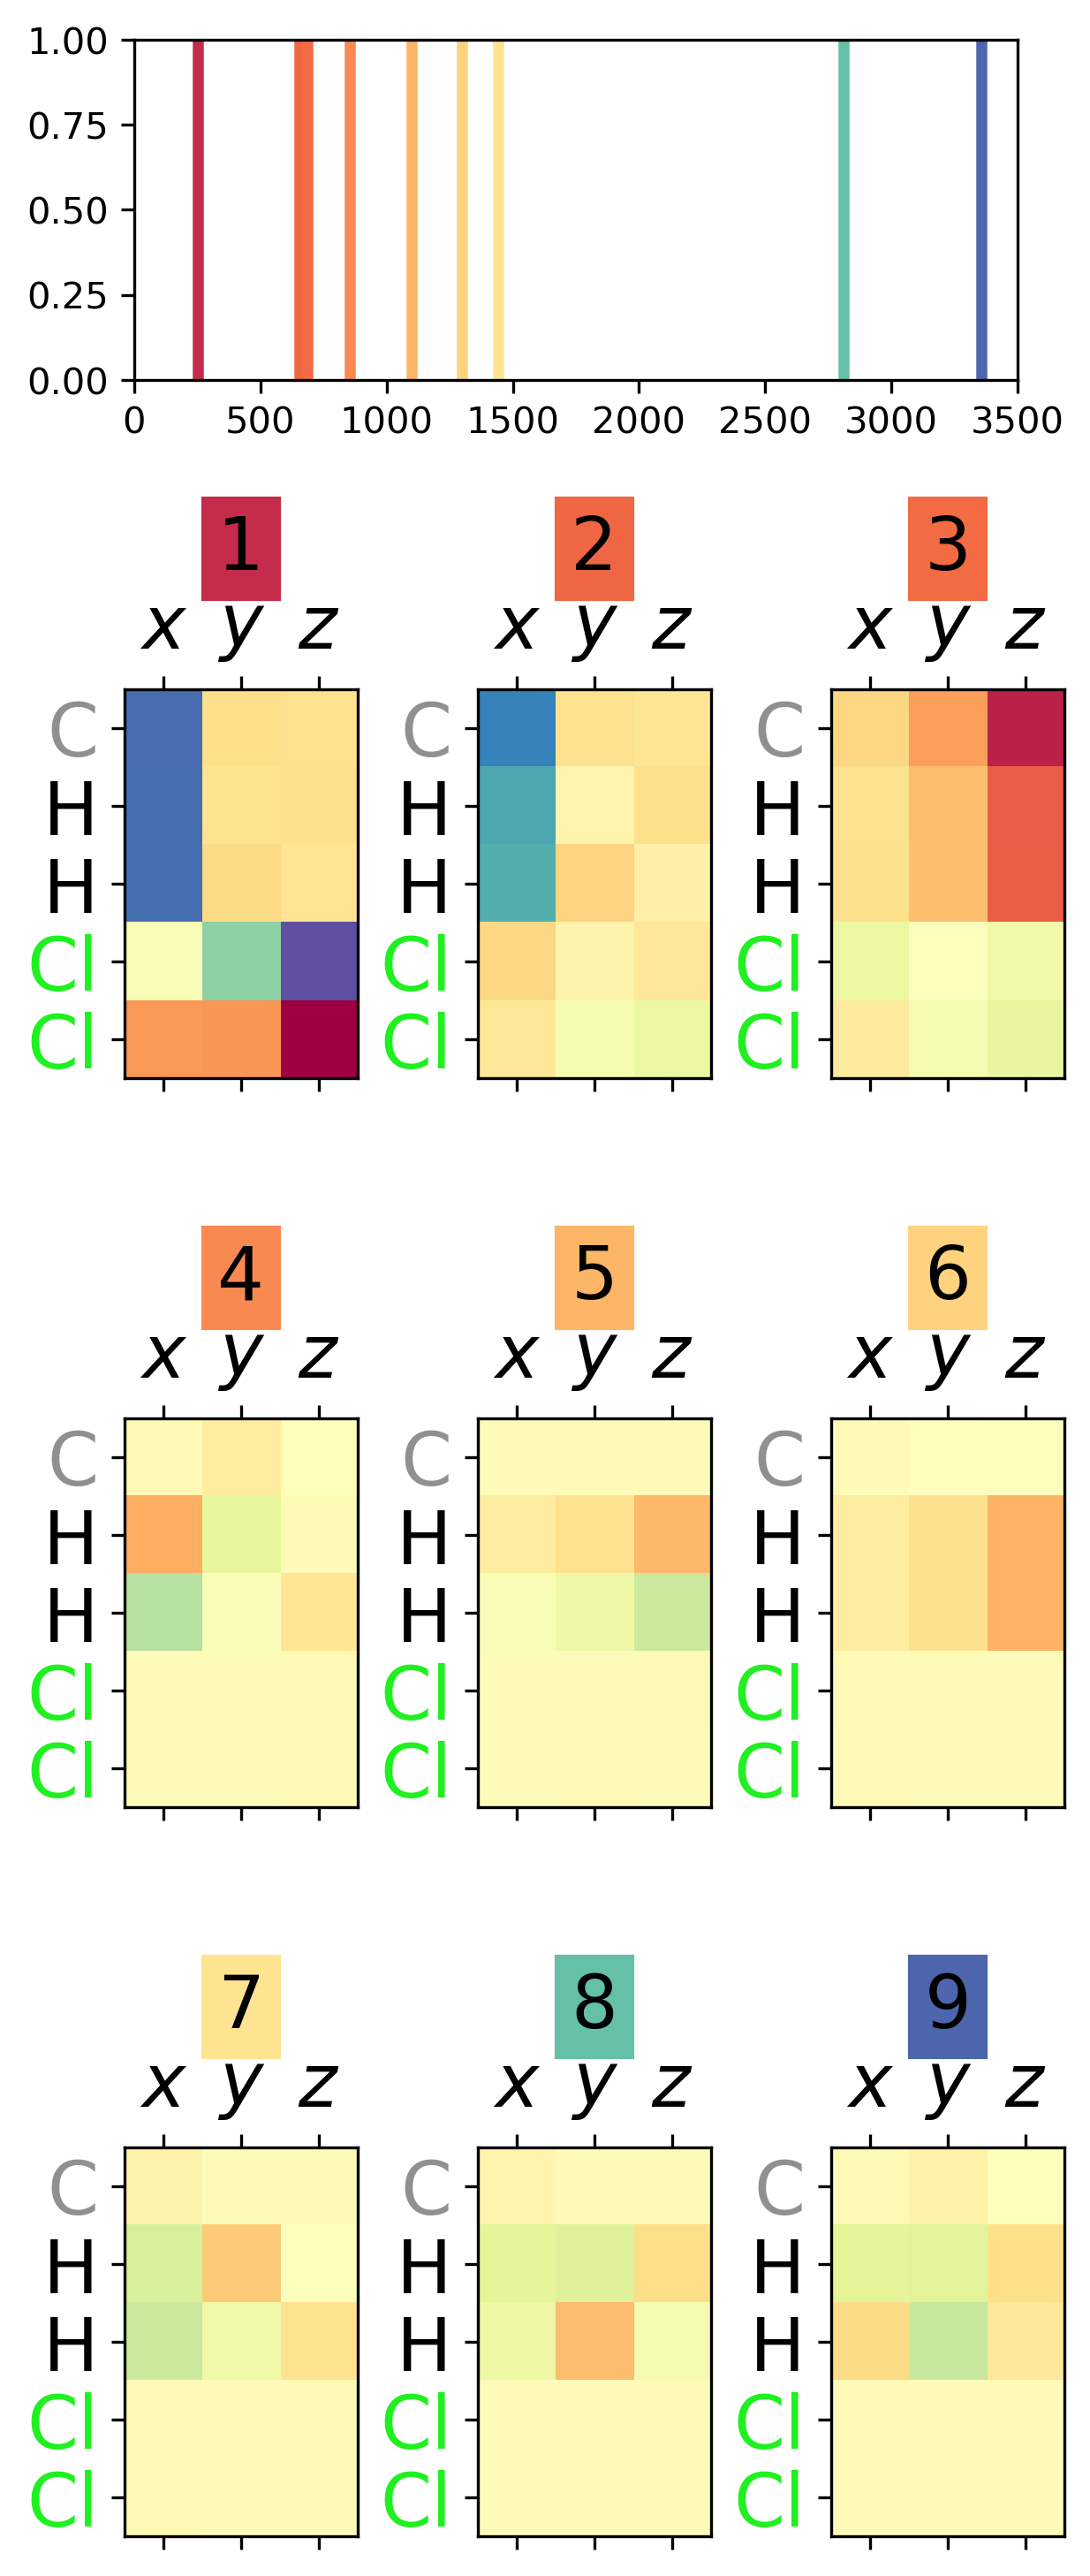

In [758]:
def make_nms_plot(index):
    result_a = results_data[index]["results_A"]
    nms = result_a["harmonic"]["norm_mode"]
    elements = result_a["mol"].elements
    rm = result_a["harmonic"]["reduced_mass"] #.keys()
    scaled = nms*rm[:,np.newaxis,np.newaxis]
    nms_plot(scaled,elements,)

make_nms_plot(10)

In [759]:
["formation_thermo"]

['formation_thermo']

In [760]:
len(result_a["harmonic"]["freq_wavenumber"])

9

(0.0, 3500.0)

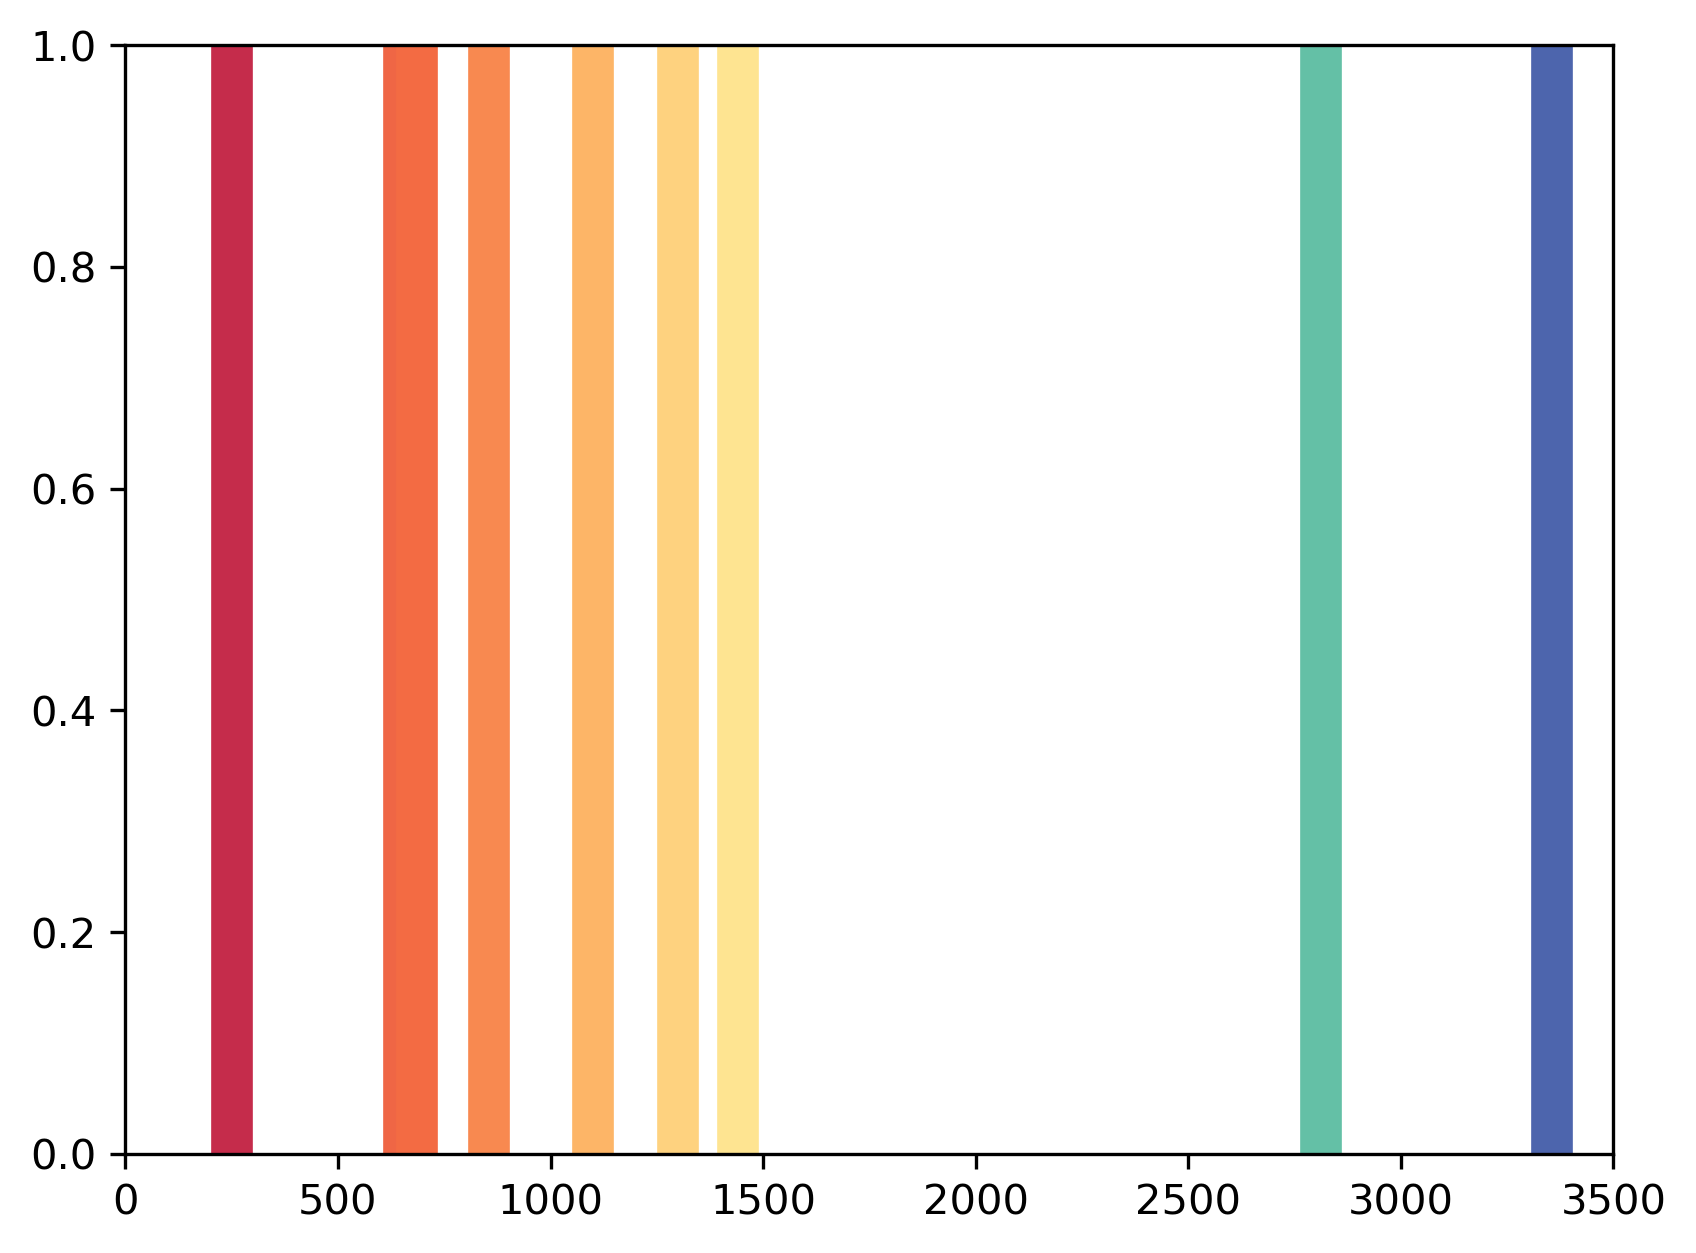

In [761]:
spectral = sns.color_palette("Spectral", as_cmap=True)

for i, x in enumerate(result_a["harmonic"]["freq_wavenumber"]):
    plt.axvline(x, color=spectral(x/3500), linewidth=10)

plt.xlim(0, 3500)

In [762]:
_ = {(i, k): data[k]["distances_"] for i, k in enumerate(keys)}
_

{(0, ('mini.pdb', 16, 293)): 8.234512918199837,
 (1, ('mini.pdb', 1, 293)): 11.69605565992228,
 (2, ('mini.pdb', 5, 293)): 15.905603572326326,
 (3, ('mini.pdb', 4, 293)): 25.08618468400486,
 (4, ('mini.pdb', 14, 293)): 17.050743356229372,
 (5, ('mini.pdb', 6, 293)): 16.93817693850197,
 (6, ('mini.pdb', 7, 293)): 20.08457271141211,
 (7, ('mini.pdb', 18, 293)): 12.813377423614742,
 (8, ('mini.pdb', 13, 293)): 14.865939324509569,
 (9, ('mini.pdb', 15, 293)): 14.604800067101227,
 (10, ('mini.pdb', 17, 293)): 10.220487904204965,
 (11, ('mini.pdb', 2, 293)): 12.076509098245237,
 (12, ('mini.pdb', 0, 293)): 25.350238401245853,
 (13, ('mini.pdb', 10, 293)): 11.790779872425741,
 (14, ('mini.pdb', 8, 293)): 7.977655858709373,
 (15, ('mini.pdb', 9, 293)): 23.68343060031633,
 (16, ('mini.pdb', 19, 293)): 16.811356935119782,
 (17, ('mini.pdb', 12, 293)): 8.619860613722244,
 (18, ('mini.pdb', 11, 293)): 11.865972231553553,
 (19, ('heat.pdb', 19, 243)): 17.773081134119654,
 (20, ('heat.pdb', 18, 243)

In [763]:
_ = pd.concat( [data[k]["intE_results"] for k in keys] )
_.index = keys
_ * 627.509

E_AB            E_A            E_B      E_A_ghost  \
mini.pdb    16 293 -1.204503e+06 -602251.390810 -602251.420291 -602251.396560   
            1  293 -1.204503e+06 -602251.450678 -602251.420291 -602251.450785   
            5  293 -1.204503e+06 -602251.437463 -602251.420291 -602251.437455   
            4  293 -1.204503e+06 -602251.472826 -602251.420291 -602251.472823   
            14 293 -1.204503e+06 -602251.405617 -602251.420291 -602251.405595   
...                          ...            ...            ...            ...   
dyna.14.pdb 9  106 -1.204499e+06 -602248.919120 -602249.971934 -602248.919116   
            1  106 -1.204501e+06 -602250.615255 -602249.971934 -602250.615233   
            4  106 -1.204500e+06 -602250.168104 -602249.971934 -602250.168100   
            11 106 -1.204501e+06 -602251.265874 -602249.971934 -602251.265873   
            3  106 -1.204500e+06 -602250.050505 -602249.971934 -602250.050502   

                        E_B_ghost  IE_no_bsse  IE_energy_bsse  
mini.pdb    16 293 -602251.428002   -0.030640       -0.017179  
            1  293 -602251.420382   -0.014171       -0.013973  
            5  293 -602251.420294    0.006553        0.006548  
            4  293 -602251.420289    0.002730        0.002724  
            14 293 -602251.420270   -0.000307       -0.000351  
...                           ...         ...             ...  
dyna.14.pdb 9  106 -602249.971908   -0.000636       -0.000665  
            1  106 -602249.971913   -0.006989       -0.007032  
            4  106 -602249.971927   -0.004066       -0.004077  
            11 106 -602249.971932    0.000321        0.000319  
            3  106 -602249.971932    0.002132        0.002126  

[235 rows x 7 columns]

-0.2

-0.1

0

0.1

0.2



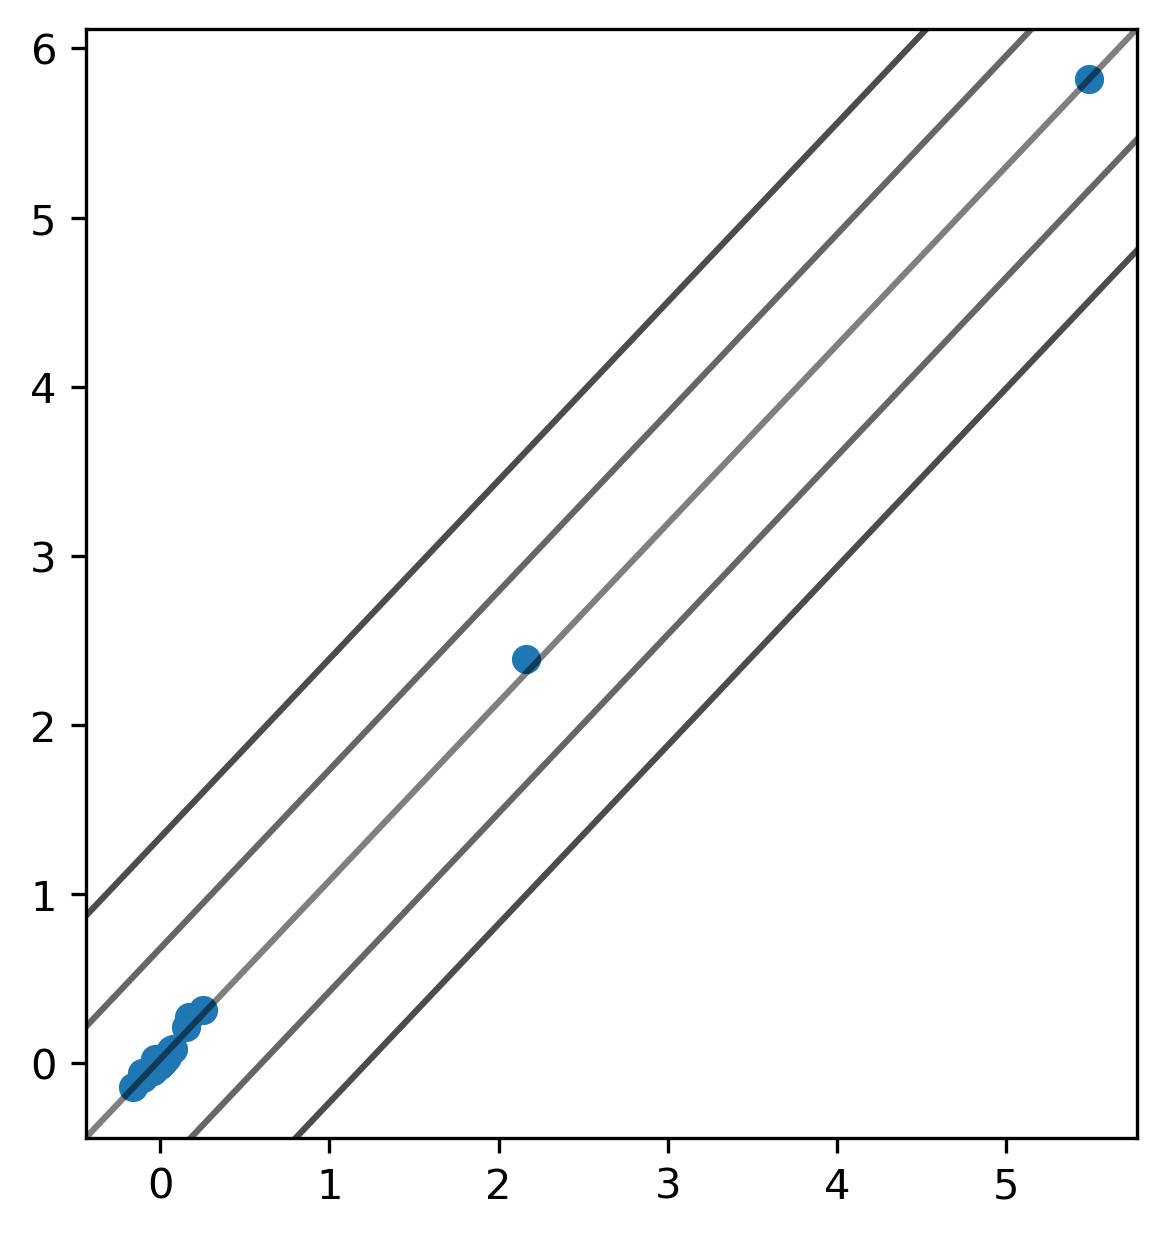

In [764]:
abc = _ * 627.509
import matplotlib.pyplot as plt
plt.scatter(abc["IE_no_bsse"], abc["IE_energy_bsse"])
ax = plt.gca()

for i in [-0.2, -0.1, 0, 0.1, 0.2]:
    print(i)
    aa = 1 - i
    print()
    ax.plot([0, 1], [0 + i, 1 + i], transform=ax.transAxes, color="k", alpha= 0.5 + abs(i))
ax.set_aspect("equal")

In [765]:
hessians = np.array([data[k]["hessians"] for k in keys]) 
hessians.shape
900/25


36.0

In [766]:
data[k].keys()
data[k]["hessians"]["results_A"].shape
atom_axes_names = ["".join(_) for _ in list(itertools.product(elements, elements))]
z = ["".join(_) for _ in list(itertools.product(["X","Y","Z"],["X","Y","Z"]))]

TypeError: unhashable type: 'list'

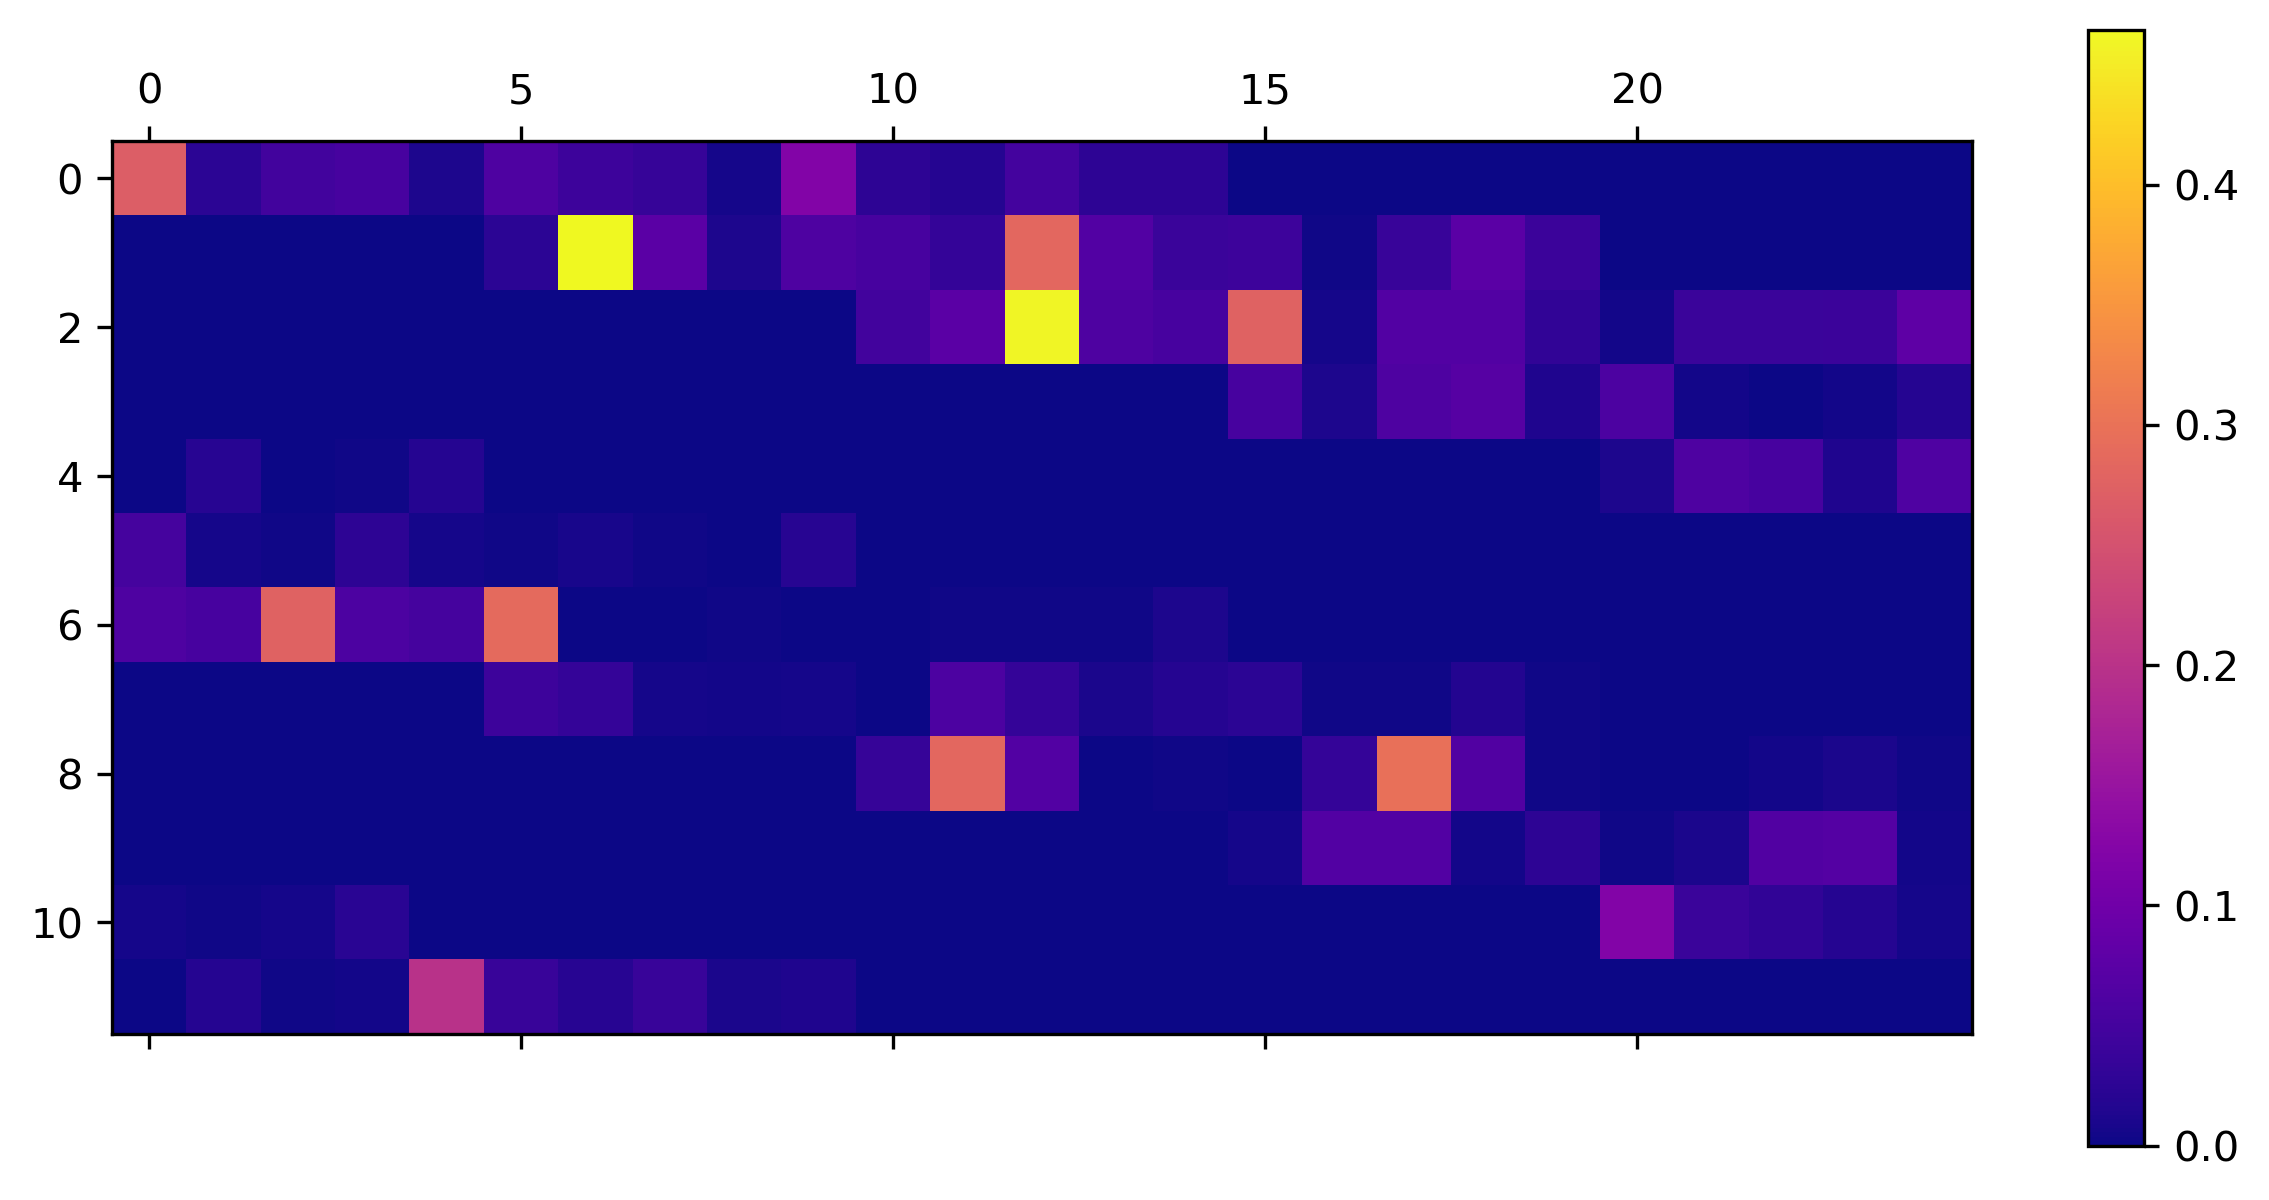

In [647]:
hess_flat = data[k]["hessians"]["results_A"].reshape(36,25)
plt.matshow(abs(hess_flat[:12]), cmap="plasma")
# plt.xticks(range(25), atom_axes_names, rotation = 45, fontsize=10)
# plt.yticks(range(12), z[:12])
plt.colorbar()

In [643]:
from functools import reduce

def factors(n):
    return set(reduce(
        list.__add__,
        ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [641]:
# factors(900)
atom_axes_names

['CC',
 'CH',
 'CH',
 'CCl',
 'CCl',
 'HC',
 'HH',
 'HH',
 'HCl',
 'HCl',
 'HC',
 'HH',
 'HH',
 'HCl',
 'HCl',
 'ClC',
 'ClH',
 'ClH',
 'ClCl',
 'ClCl',
 'ClC',
 'ClH',
 'ClH',
 'ClCl',
 'ClCl']